In [1]:
import gymnasium as gym
from gymnasium.wrappers.vector import NormalizeObservation, NormalizeReward, NumpyToTorch
import torch

In [2]:
num_envs = 4
env = gym.make_vec('LunarLander-v3', num_envs = num_envs)
env = NormalizeObservation(env)
# env = NormalizeReward(env)
env = NumpyToTorch(env)

In [3]:
env.observation_space

Box([[ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]
 [ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
   -0.         -0.       ]], [[ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]
 [ 2.5        2.5       10.        10.         6.2831855 10.
   1.         1.       ]], (4, 8), float32)

In [4]:
obs_sample = env.observation_space.sample()
obs_sample

array([[-0.7164181 , -1.6647979 ,  1.7653198 , -2.8230062 ,  5.3642    ,
         6.34968   ,  0.08954923,  0.09008829],
       [-1.250356  ,  1.3136407 , -8.999325  , -5.6372886 , -2.4706852 ,
         3.1255288 ,  0.75477195,  0.02842116],
       [-1.815966  ,  1.4513835 ,  7.05519   , -9.45907   , -3.9381962 ,
         7.521108  ,  0.86670005,  0.27389407],
       [ 0.12886027, -1.5640498 ,  2.284174  , -4.4057736 ,  0.44685674,
         9.0422735 ,  0.01334901,  0.79373807]], dtype=float32)

In [5]:
obs_sample.shape

(4, 8)

In [6]:
env.action_space

MultiDiscrete([4 4 4 4])

In [7]:
actions_sample = env.action_space.sample()
actions_sample

array([2, 2, 2, 1])

In [8]:
states, info = env.reset()
states

tensor([[ 1.0412, -0.4556,  1.6158, -0.7181, -1.1289, -1.6138,  0.0000,  0.0000],
        [-0.6364, -0.1345, -0.9876, -0.2155,  0.6900,  0.9864,  0.0000,  0.0000],
        [-0.4141,  1.0839, -0.6426,  1.6918,  0.4489,  0.6418,  0.0000,  0.0000],
        [ 0.0093, -0.4813,  0.0144, -0.7583, -0.0101, -0.0144,  0.0000,  0.0000]])

In [9]:
next_states, rewards, dones, terminated, _ = env.step(actions_sample)

In [10]:
next_states

tensor([[ 1.8621, -0.9077,  1.6315, -0.6034, -1.9108, -1.5779,  0.0000,  0.0000],
        [-1.0500, -0.4216, -0.9885, -0.2178,  1.0367,  0.8898,  0.0000,  0.0000],
        [-0.6793,  1.6794, -0.6670,  1.7107,  0.5784,  0.4432,  0.0000,  0.0000],
        [ 0.0604, -1.0630, -0.0037, -0.8456,  0.1660,  0.4060,  0.0000,  0.0000]])

In [11]:
rewards

tensor([ 0.6920, -0.4681, -3.1747, -1.2513], dtype=torch.float64)

In [12]:
dones # done is when state successfully finished or passed

tensor([False, False, False, False])

In [13]:
terminated # terminated is when agent failed 

tensor([False, False, False, False])

In [14]:
from src.ppo import *
import random
import numpy as np
from src.tune_hyperparams import return_obj
import optuna

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

/home/zhutchens/projects/RL/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda')

In [15]:
actor = Actor(8, 4, 213).to(device)
critic = Critic(8, 1, 101).to(device)

In [16]:
obs_sample = torch.from_numpy(obs_sample).to(device)
dist = actor.forward(obs_sample)
dist

Categorical(logits: torch.Size([4, 4]))

In [17]:
test_sample = dist.sample()

In [18]:
dist.log_prob(test_sample)

tensor([-1.5014, -1.1902, -1.2524, -1.4508], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [19]:
dist.log_prob(test_sample).exp()

tensor([0.2228, 0.3042, 0.2858, 0.2344], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [20]:
critic.forward(obs_sample)

tensor([[0.3460],
        [0.1994],
        [0.8412],
        [0.4784]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
# params = {
#     "actor_in_feats": (8, 8, "int"),
#     "actor_out_feats": (4, 4, "int"),
#     "actor_hs": (64, 512, "int"),
#     "critic_in_feats": (8, 8, "int"),
#     "critic_out_feats": (1, 1, "int"),
#     "critic_hs": (64, 512, "int"),
#     "epsilon": (0.1, 0.3, "float"),
#     "gamma": (0.95, 0.999, "float"),
#     "lambda": (0.9, 0.99, "float"),
#     "actor_lr": (1e-5, 1e-3, "float"),
#     "critic_lr": (1e-5, 1e-3, "float"),
#     "batch_size": (64, 1024, "int"),
#     "c1": (0.1, 1.0, "float"), # value func. coefficient
#     "c2": (0.001, 0.05, "float") # entropy bonus
# }

# objective = return_obj(env, device, 200, 1024, 4, train, params)
# sampler = optuna.samplers.TPESampler(multivariate = True, n_startup_trials = 2)
# study = optuna.create_study(direction = 'maximize', study_name = 'lunar lander tune', sampler = sampler)
# study.optimize(objective, n_trials = 50)

In [22]:
# study.best_params

In [23]:
agent = Agent(actor, critic, 0.1, 0.99691, 0.98463, 0.1349, 0.02401, 0.0003009, 0.0003726, device, 660)

In [24]:
train(env, agent, num_envs, 2000, 1024, 4, 'models/lunarlander_agent.pt', True) 

finished episode: 0
total reward: -8132.002313908999
number of steps: 1024
---------------
new best model... saving...
finished episode: 1
total reward: -7001.197169552015
number of steps: 1024
---------------
new best model... saving...
finished episode: 2
total reward: -5205.232981115693
number of steps: 1024
---------------
new best model... saving...
finished episode: 3
total reward: -5590.817511859356
number of steps: 1024
---------------
finished episode: 4
total reward: -4498.066775053762
number of steps: 1024
---------------
new best model... saving...
finished episode: 5
total reward: -4661.0999272572435
number of steps: 1024
---------------
finished episode: 6
total reward: -3764.8341890152738
number of steps: 1024
---------------
new best model... saving...
finished episode: 7
total reward: -3819.29947394122
number of steps: 1024
---------------
finished episode: 8
total reward: -3260.1361244894024
number of steps: 1024
---------------
new best model... saving...
finished ep

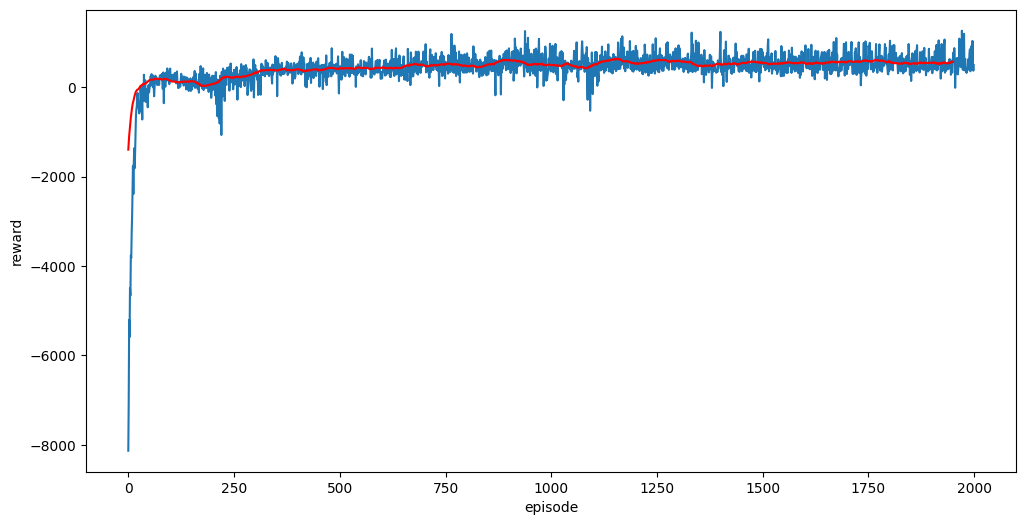

In [25]:
import matplotlib.pyplot as plt
window_size = 50
running_avg = []

for i in range(len(agent.all_rewards) - window_size + 1):
    window_sum = sum(agent.all_rewards[i:i + window_size])
    average = window_sum / window_size
    running_avg.append(average)

plt.figure(figsize = (12, 6))
plt.xlabel('episode')
plt.ylabel('reward')
plt.plot(agent.all_rewards)
plt.plot(running_avg, color = 'red')

In [31]:
agent.save_agent('models/lunarlander_agent.pt')

In [29]:
# saving environment statistics
mean = env.env.obs_rms.mean
var = env.env.obs_rms.var

In [30]:
env_mean = np.save('environment/lunarlander_env_mean', mean)
env_var = np.save('environment/lunarlander_env_var', var)